# Monte Carlo Simulation
Monte Carlo simulations, on the other hand, are a powerful tool for assessing the performance of trading strategies. By generating random scenarios and simulating the trading strategy across a large number of iterations, Monte Carlo simulations provide insights into the potential outcomes of the strategy and help evaluate its robustness and stability.

#### Trading strategy
This notebook will implement a simple yet popular trading strategy in which a long position will be taken in an asset as long as the asset is trading above the 200 day simple moving average.

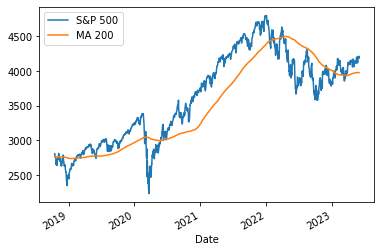

In [1]:
from datetime import datetime
import pandas as pd
import yfinance as yf

sp500 = yf.download('^GSPC','2018-01-01',datetime.today(), progress=False)['Close'].rename('S&P 500')
ma_200 = sp500.rolling(window=200).mean().rename('MA 200')
data = pd.concat([sp500, ma_200], axis=1).dropna()
data.plot();

In [4]:
data['long'] = data['MA 200'] < data['S&P 500']

In [7]:
initial_investment = data[data['long']]['S&P 500'][0]
data['return'] = data['S&P 500'].pct_change()
data.loc[~data['long'], 'return'] = 0

data.dropna(inplace=True)
final_investment = initial_investment
for r in data['return']:
    final_investment *= r + 1

print('Final value: {}'.format(round(final_investment, 4)))
print('Final value (% of investment): {:.2%}'.format(round(final_investment/ initial_investment, 4)))

Final value: 7294.4125
Final value (% of investment): 259.60%


## Monte Carlo: Black-Scholes

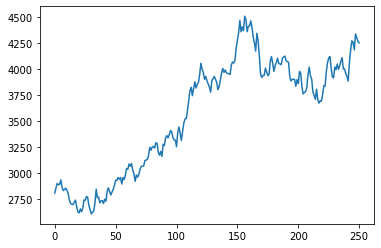

In [22]:
import numpy as np

def simulate_stock_prices(S0, sigma, num_steps, drift=0.1):
    """
    Simulates stock prices under the Black-Scholes model (no drift) using Monte Carlo simulations.

    Parameters:
        S0 (float): Initial stock price.
        sigma (float): Volatility of the stock.
        num_simulations (int): Number of simulations to run.
        num_steps (int): Number of time steps for each simulation.

    Returns:
        array-like: Array of simulated stock prices.
    """
    dt = 1 / num_steps
    sqrt_dt = np.sqrt(dt)
    drift_dt = drift / num_steps

    stock_prices = [S0]

    for i in range(num_steps):
        z = np.random.standard_normal()
        stock_prices.append(stock_prices[i] * (1+drift_dt) * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * z))
    return stock_prices

prices = simulate_stock_prices(initial_investment, 0.25,  250)
pd.Series(prices).plot();

In [23]:
final_values = []

for i in range(1000):
    prices = simulate_stock_prices(initial_investment, 0.25,  250)
    prices = pd.Series(prices).rename('price')
    ma_200 = prices.rolling(window=200).mean().rename('MA 200')
    data = pd.concat([prices, ma_200], axis=1).dropna()
    data['long'] = data['MA 200'] < data['price']
    data['return'] = data['price'].pct_change()
    data.loc[~data['long'], 'return'] = 0
    data.dropna(inplace=True)
    final_investment = initial_investment
    for r in data['return']:
        final_investment *= r + 1
    final_values.append(final_investment)

print('Final value: {}'.format(round(np.mean(final_values), 4)))
print('Final value (% of investment): {:.2%}'.format(round(np.mean(final_values)/ initial_investment, 4)))

Final value: 2966.399
Final value (% of investment): 105.57%


### Monte Carlo Heston

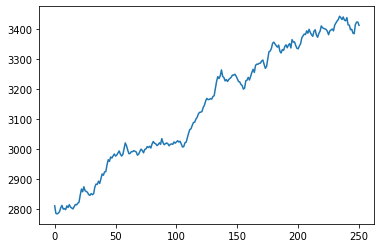

In [31]:
import numpy as np

def simulate_stock_prices_heston(S0, sigma, num_steps, drift=0.1):
    """
    Simulates stock prices under the Heston model using Monte Carlo simulations.

    Parameters:
        S0 (float): Initial stock price.
        sigma (float): Volatility of the stock.
        num_steps (int): Number of time steps for each simulation.
        drift (float): Drift parameter.

    Returns:
        array-like: Array of simulated stock prices.
    """
    dt = 1 / num_steps
    sqrt_dt = np.sqrt(dt)
    drift_dt = drift / num_steps
    rho = 0.5
    theta = sigma

    stock_prices = [S0]

    for i in range(num_steps):
        z1 = np.random.standard_normal()
        z2 = np.random.standard_normal()
        dW1 = np.sqrt(dt) * z1
        dW2 = np.sqrt(dt) * (rho * z1 + np.sqrt(1 - rho**2) * z2)
        stock_prices.append(stock_prices[i] * (1+drift_dt) + sigma * np.sqrt(stock_prices[i]) * dW1 * (theta - stock_prices[i]) * dt + sigma * np.sqrt(stock_prices[i]) * dW2)
    return stock_prices

prices = simulate_stock_prices_heston(initial_investment, 0.25,  250)
pd.Series(prices).plot();


In [32]:
final_values = []
for i in range(1000):
    prices = simulate_stock_prices_heston(initial_investment, 0.25,  250)
    prices = pd.Series(prices).rename('price')
    ma_200 = prices.rolling(window=200).mean().rename('MA 200')
    data = pd.concat([prices, ma_200], axis=1).dropna()
    data['long'] = data['MA 200'] < data['price']
    data['return'] = data['price'].pct_change()
    data.loc[~data['long'], 'return'] = 0

    data.dropna(inplace=True)
    final_investment = initial_investment
    for r in data['return']:
        final_investment *= r + 1
    final_values.append(final_investment)

print('Final value: {}'.format(round(np.mean(final_values), 4)))
print('Final value (% of investment): {:.2%}'.format(round(np.mean(final_values)/ initial_investment, 4)))

Final value: 2871.3279
Final value (% of investment): 102.19%
